# Liu et al optimal sigma

In [22]:
import numpy as np
import pandas as pd
import torch
from sklearn.datasets import make_classification,make_moons, load_wine, load_iris
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
def sigma_selection_torch(X, y, method='w1'):
    """
    PyTorch version of sigmaSelection.m by Zhiliang Liu (2013).

    Args:
        X (Tensor): (N, D) feature matrix
        y (Tensor): (N,) integer class labels
        method (str): either 'w1' or 'w2'

    Returns:
        opt_sigma (float): optimal sigma
        B_bar (float)
        W_bar (float)
    """
    assert method in ['w1', 'w2'], "method must be 'w1' or 'w2'"

    X = torch.tensor(X,dtype=torch.float32)
    y = torch.tensor(y,dtype=torch.long)
    X = (X - X.mean(dim=0)) / (X.std(dim=0) + 1e-8)  # Z-score normalization

    classes = torch.unique(y)
    n_class = len(classes)
    n_samples = X.shape[0]
    class_sizes = torch.tensor([(y == c).sum() for c in classes], dtype=torch.float32)
    W_sum, B_sum = 0.0, 0.0

    for i in range(n_class):
        for j in range(i, n_class):
            idx_i = (y == classes[i])
            idx_j = (y == classes[j])
            Xi = X[idx_i]
            Xj = X[idx_j]
            dist_sum = euclidean_matrix_sum(Xi, Xj)
            if i == j:
                W_sum += dist_sum
            else:
                B_sum += dist_sum

    nW = (class_sizes**2).sum().item()
    nB = (n_samples**2 - nW) / 2
    W_bar = W_sum / nW
    B_bar = B_sum / nB

    if W_bar >= B_bar:
        raise ValueError("W_bar >= B_bar! The method is not applicable!")

    log_ratio = torch.log(torch.tensor(B_bar / W_bar))
    if method == 'w1':
        opt_sigma = torch.sqrt((B_bar - W_bar) / (2 * log_ratio))
    else:  # method == 'w2'
        opt_sigma = torch.sqrt((B_bar - W_bar) / (4 * log_ratio))

    return opt_sigma.item()

def euclidean_matrix_sum(X, Y, block_size=1000):
    """
    Computes the sum of squared pairwise Euclidean distances between two matrices.
    """
    X = X.float()
    Y = Y.float()
    mSum = 0.0
    n1, n2 = X.shape[0], Y.shape[0]

    for i in range(0, n1, block_size):
        i_end = min(i + block_size, n1)
        Xi = X[i:i_end]
        for j in range(0, n2, block_size):
            j_end = min(j + block_size, n2)
            Yj = Y[j:j_end]
            dist = torch.cdist(Xi, Yj, p=2) ** 2
            mSum += dist.sum().item()
    return mSum


In [24]:
# X: torch.tensor (N, D)
# y: torch.tensor (N,)

# X, y = make_moons(n_samples=385, noise=0.1, random_state=0, shuffle=False)
# X, y = make_classification(n_samples=500, n_classes=3, weights=[0.7, 0.2, 0.1], n_informative=5, n_features=10, random_state=42)
# X,y = load_iris(return_X_y=True)
# Convert properly to torch tensors
# X_tensor = torch.from_numpy(X).float()
# y_tensor = torch.from_numpy(y).long()
# print(X_tensor.shape, y_tensor.shape, np.unique(y_tensor).shape[0])

# opt_sigma,B_bar, W_bar = sigma_selection_torch(X, y, method='w1')
# print(f"Optimal σ: {opt_sigma:.4f}")

# class weighted sigma


In [25]:
# ---------- Label Propagation ----------
def lpa_predict(x, y, sigma,split):

    # divide the data into train-test
    id = np.arange(len(x))
    X_train, X_test, Y_train, Y_test, idx_train, idx_test = train_test_split(x, y, id, test_size=split,stratify=y, random_state=42)

    # vertically stack X_train and X-test.
    shuffled_features = np.vstack((X_train, X_test))

    # compute guassian distance between the data points to get the adjacency matrix (weight matrix)
    pairwise_sq_dists = squareform(pdist(shuffled_features, 'euclidean'))
    weight = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    np.fill_diagonal(weight, 0)

    # Transition matrix
    Tran = weight / np.sum(weight, axis=0)
    row_sums = np.sum(Tran, axis=1)
    T = Tran / row_sums

    # combine the y_train and y_test to get the combined y (labels of data points)
    y_concat = np.concatenate((Y_train, Y_test))
    y_onehot = pd.get_dummies((y_concat), dtype=float).values  # labels converted to one-hot encoded form

    # Removing labels for test data points
    y_new = y_onehot.copy()
    y_new[Y_train.shape[0]:] = [0, 0, 0]  # Assuming 3 classes for Iris dataset
    y_labeled = y_new[:Y_train.shape[0]]

    # partitioning transition matrix
    T_ll = T[:y_labeled.shape[0], :y_labeled.shape[0]]
    T_lu = T[:y_labeled.shape[0], y_labeled.shape[0]:]
    T_ul = T[y_labeled.shape[0]:, :y_labeled.shape[0]]
    T_uu = T[y_labeled.shape[0]:, y_labeled.shape[0]:]

    # Predicting labels for test data points
    I = np.identity(T_uu.shape[0])
    YU = np.linalg.inv(I - T_uu).dot(T_ul).dot(y_labeled)

    y_pred = np.argmax(YU, axis=1)
    y_actual = np.argmax(y_onehot[Y_train.shape[0]:], axis=1)

    # Accuracy and F1 score
    accuracy = accuracy_score(y_pred, y_actual)
    f1_value = f1_score(y_pred, y_actual, average='macro')

    return y_pred, y_actual, accuracy,f1_value

In [26]:
# ---------- Sigma Estimators ----------
def median_sigma(X):
    X_tensor = torch.from_numpy(X).float()
    dists = torch.cdist(X_tensor, X_tensor, p=2)
    median_val = torch.median(dists[dists > 0])
    return median_val.item()

def sqrt_median_div_3_sigma(X):
    X_tensor = torch.from_numpy(X).float()
    dists = torch.cdist(X_tensor, X_tensor, p=2)
    median_sq = torch.median(dists[dists > 0])
    return torch.sqrt(median_sq / 3).item()

def sigma_selection_class_weighted(X, y, use_weights=True):
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).long()
    device = X.device
    classes = torch.unique(y)
    W_sum, B_sum = 0.0, 0.0
    W_weight, B_weight = 0.0, 0.0

    for i in range(len(classes)):
        for j in range(i, len(classes)):
            idx_i = (y == classes[i])
            idx_j = (y == classes[j])
            Xi, Xj = X[idx_i], X[idx_j]

            if Xi.shape[0] == 0 or Xj.shape[0] == 0:
                continue

            dist_sum = (torch.cdist(Xi, Xj, p=2) ** 2).sum().item()

            if i == j:
                w = 1.0 / (Xi.shape[0] ** 2) if use_weights else 1.0
                W_sum += w * dist_sum
                W_weight += 1
            else:
                w = 1.0 / (Xi.shape[0] * Xj.shape[0]) if use_weights else 1.0
                B_sum += w * dist_sum
                B_weight += 1

    W_bar = W_sum / W_weight
    B_bar = B_sum / B_weight

    if W_bar >= B_bar:
        raise ValueError("W̄ ≥ B̄ — Liu's method not applicable.")

    W_bar_t = torch.tensor(W_bar)
    B_bar_t = torch.tensor(B_bar)
    sigma = torch.sqrt((B_bar_t - W_bar_t) / (2 * torch.log(B_bar_t / W_bar_t)))
    return sigma.item()

median                 σ = 9.2613 → Accuracy = 0.6956, Macro-F1 = 0.2735
sqrt(median/3)         σ = 1.7570 → Accuracy = 0.6956, Macro-F1 = 0.2735
liu                    σ = 3.1630 → Accuracy = 0.6956, Macro-F1 = 0.2735
class_weighted_liu     σ = 7.2075 → Accuracy = 0.6956, Macro-F1 = 0.2735


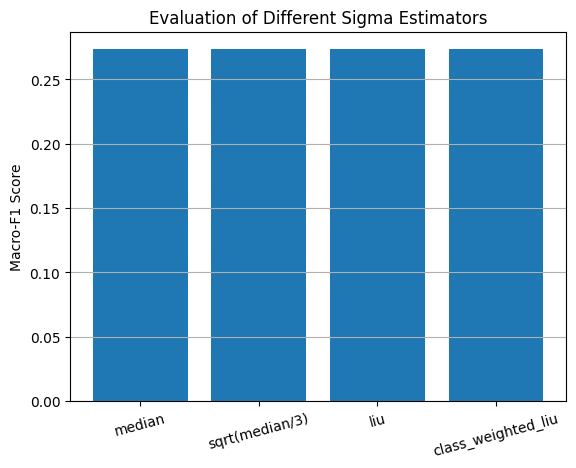

In [ ]:
# ---------- Main Evaluation ----------
def run_sigma_eval(X_np, y_np):
    # Create imbalanced dataset
    results = {}
    sigma_methods = {
        "median": median_sigma,
        "sqrt(median/3)": sqrt_median_div_3_sigma,
        "liu": lambda X: sigma_selection_torch(X_np, y_np, method='w1'),
        "class_weighted_liu": lambda X: sigma_selection_class_weighted(X_np, y_np)
    }

    for name, sigma_fn in sigma_methods.items():
        try:
            sigma = sigma_fn(X_np)
            y_pred,y_actual,acc,macro_f1 = lpa_predict(X_np, y_np,sigma,0.3)
            results[name] = (sigma, macro_f1)
            print(f"{name:22s} σ = {sigma:.4f} → Accuracy = {acc:.4f}, Macro-F1 = {macro_f1:.4f}")
        except Exception as e:
            print(f"{name:22s} failed: {e}")
            results[name] = (None, 0)

    # Plot
    plt.bar(results.keys(), [v[1] for v in results.values()])
    plt.ylabel("Macro-F1 Score")
    plt.title("Evaluation of Different Sigma Estimators")
    plt.xticks(rotation=15)
    plt.grid(True, axis='y')
    plt.show()




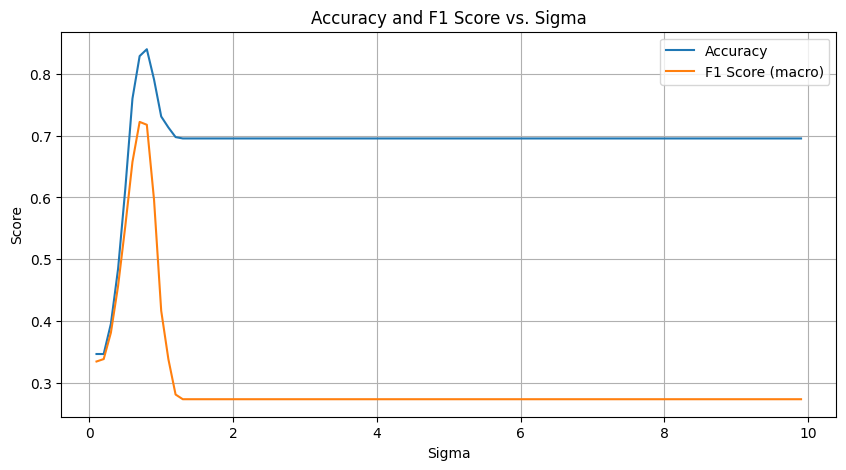

In [ ]:
# plotting the results
import matplotlib.pyplot as plt
X_np, y_np = make_classification(n_samples=1500, n_features=10, n_classes=3,
                                     n_informative=8,weights=[0.7, 0.1, 0.2],
                                     random_state=0)
# X_np,y_np = load_iris(return_X_y=True)

# Run evaluation
run_sigma_eval()

#Optimal sigma
sigma_values = np.arange(0.1, 10.0, 0.1)
accuracy_values = []
f1_values = []

for i in sigma_values:
    y_pred, y_actual, acc, f1_value = lpa_predict(x, y, i,0.3)
    accuracy_values.append(acc)
    f1_values.append(f1_value)

plt.figure(figsize=(10, 5))
plt.plot(sigma_values, accuracy_values, label='Accuracy')
plt.plot(sigma_values, f1_values, label='F1 Score (macro)')
plt.xlabel('Sigma')
plt.ylabel('Score')
plt.title('Accuracy and F1 Score vs. Sigma')
plt.legend()
plt.grid(True)
plt.show()

# optimal sigma 

In [29]:
def compute_sigma(X):
    N = X.shape[0]
    sq_dists = []
    for i in range(N):
        for j in range(i+1, N):
            sq_dists.append(np.sum((X[i] - X[j])**2))
    med_sq = np.median(sq_dists)
    sigma = np.sqrt(med_sq / 3)
    print("computed sigma",sigma)
    return sigma

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import ListedColormap
from sklearn.metrics import f1_score

def plot_multiple_sigmas(X_np, labeled_indices, labels_partial,y_moons_unlabeled, base_sigma,
                         low_factor=0.85, high_factor=1.25, step_factor=0.05):

    factors = np.arange(low_factor, high_factor + step_factor, step_factor)
    factors = [round(f, 2) for f in factors]
    sigmas = [f * base_sigma for f in factors]

    # Calculate grid dimensions for subplots
    n_sigmas = len(sigmas)
    n_cols = 4
    n_rows = (n_sigmas + n_cols - 1) // n_cols

    # plt.figure(figsize=(5 * n_cols, 4 * n_rows))
    # plt.suptitle(f"Label Propagation Results with Varying σ (Base σ={base_sigma:.4f})", fontsize=16)

    for i, sigma_val in enumerate(sigmas):
        # Run label propagation with current sigma        
        print(f"For simga value: {sigma_val}")
        pred1 = label_propagation(torch.from_numpy(X_np).float(), labeled_indices, labels_partial,sigma=sigma_val)
        print("Accuracy:",np.mean(y_moons_unlabeled == pred1.cpu().numpy()))
        print("F1 Score:",f1_score(y_moons_unlabeled, pred1.cpu().numpy(), average='macro'))


# --- Compute Base Sigma ---
base_sigma = compute_sigma(X.cpu().numpy())

# --- Plot Results for Multiple Sigmas ---
plot_multiple_sigmas(X.cpu().numpy(),
    idx_train.tolist(),
    y_train, y_test,
    base_sigma,
    low_factor=0.5,
    high_factor=2.0,
    step_factor=0.1
)

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:
import torch

def euclidean_matrix_sum(X, Y, block_size=1000):
    """Compute sum of squared pairwise Euclidean distances between X and Y."""
    mSum = 0
    nX, nY = X.shape[0], Y.shape[0]
    for i in range(0, nX, block_size):
        Xi = X[i:i+block_size]
        for j in range(0, nY, block_size):
            Yj = Y[j:j+block_size]
            dist = torch.cdist(Xi, Yj, p=2) ** 2
            mSum += dist.sum().item()
    return mSum

def sigma_selection_class_weighted(X, y, method='w1'):
    """
    Computes optimal sigma using Liu's method with class size weighting.
    X: (N, d) tensor
    y: (N,) tensor of class labels
    """
    X = X.float()
    y = y.long()
    classes = torch.unique(y)
    n_class = len(classes)
    n_samples = X.shape[0]

    W_sum = 0.0
    B_sum = 0.0
    W_weight = 0.0
    B_weight = 0.0

    for i in range(n_class):
        for j in range(i, n_class):
            idx_i = (y == classes[i])
            idx_j = (y == classes[j])
            Xi = X[idx_i]
            Xj = X[idx_j]

            if Xi.shape[0] == 0 or Xj.shape[0] == 0:
                continue

            dist_sum = euclidean_matrix_sum(Xi, Xj)

            if i == j:
                w = 1.0 / (Xi.shape[0] ** 2)
                W_sum += w * dist_sum
                W_weight += 1
            else:
                w = 1.0 / (Xi.shape[0] * Xj.shape[0])
                B_sum += w * dist_sum
                B_weight += 1

    if W_weight == 0 or B_weight == 0:
        raise ValueError("Insufficient class diversity for sigma estimation.")

    W_bar = W_sum / W_weight
    B_bar = B_sum / B_weight

    if W_bar >= B_bar:
        raise ValueError("W_bar >= B_bar; Liu method not applicable.")

    B_bar_t = torch.tensor(B_bar)
    W_bar_t = torch.tensor(W_bar)
    # Liu's sigma formulas
    if method == 'w1':
        sigma = torch.sqrt((B_bar_t - W_bar_t) / (2 * torch.log(B_bar_t / W_bar_t)))
    elif method == 'w2':
        sigma = torch.sqrt((B_bar_t - W_bar_t) / (4 * torch.log(B_bar_t / W_bar_t)))
    else:
        raise ValueError("Method must be 'w1' or 'w2'")

    return sigma.item(), B_bar_t, W_bar_t


In [ ]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

X_np, y_np = make_classification(n_samples=500, n_classes=3, weights=[0.7, 0.2, 0.1], n_informative=5, n_features=10, random_state=42)
X = torch.from_numpy(X_np)
y = torch.from_numpy(y_np)

sigma, B_bar, W_bar = sigma_selection_class_weighted(X, y, method='w1')
print(f"Optimal σ: {sigma:.4f}, B̄: {B_bar:.4f}, W̄: {W_bar:.4f}")


Optimal σ: 4.6980, B̄: 48.1392, W̄: 40.3741


# LPA

In [ ]:
def compute_sigma(X):
    N = X.shape[0]
    sq_dists = []
    for i in range(N):
        for j in range(i+1, N):
            sq_dists.append(np.sum((X[i] - X[j])**2))
    med_sq = np.median(sq_dists)
    sigma = np.sqrt(med_sq / 3)
    return sigma

In [ ]:
sigma = compute_sigma(X)
print(sigma)

1.3625955623979797


In [ ]:
def label_propagation(X, labeled_indices, labels_partial, sigma=None):
    N = X.shape[0]
    all_labels = np.full(N, -1)
    for i, idx in enumerate(labeled_indices):
        all_labels[idx] = labels_partial[i]

    unlabeled_indices = [i for i in range(N) if i not in labeled_indices]

    dist_matrix = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=2)
    # print(sigma)
    W = np.exp(-dist_matrix ** 2 / (2 * sigma ** 2))
    D = np.diag(W.sum(axis=1))

    W_UL = W[np.ix_(unlabeled_indices, labeled_indices)]
    W_UU = W[np.ix_(unlabeled_indices, unlabeled_indices)]

    # print(D_LL)
    k = len(np.unique(labels_partial))
    YL = np.zeros((len(labeled_indices), k))
    for i, idx in enumerate(labeled_indices):
        YL[i, all_labels[idx]] = 1

    I = np.identity(W_UU.shape[0])
    YU = np.linalg.pinv(I - W_UU).dot(W_UL).dot(YL)
    y_pred = np.argmax(YU, axis = 1)
    return y_pred

In [ ]:
all_indices = np.arange(len(X))
XL,XU, YL,YU, idx_L, idx_U = train_test_split(X, y,all_indices, test_size=0.3, random_state=42)


In [ ]:
from sklearn.metrics import f1_score
YU_pred = label_propagation(X, idx_L, YL,sigma)
print("F1 Score is:",f1_score(YU, YU_pred, average='macro'))

F1 Score is: 0.3625420292086959
